This notebook is for experimenting with ```new parts``` in the main  notebook file
## Natural Pandemics
1. spot errors in the plot file & computed_gpd function
2. reproduce maximum likelihood estimation for gpd model
3. calculate standard error and tired CI
4. goodness of fit tests

In [48]:
from helpers import *
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
params = Params()

In [16]:
marani_xls = params.Natural.dataset.val
marani_df, disease_totals = load_and_preprocess_natural_data(marani_xls)

In [17]:
# drop the row with NaN
marani_df = marani_df.dropna(subset=["Intensity (deaths per thousand/year)"])
marani_df["Intensity (deaths per thousand/year)"].isna().sum()

0

In [18]:
marani_1e_5_df = marani_df[(marani_df["Intensity (deaths per thousand/year)"] > 1e-5) & (marani_df["Start Year"].between(1600, 1944))]

In [19]:
sorted_data = marani_df.sort_values(by='Intensity (deaths per thousand/year)', ascending=True)
exceedance_probs = 1 - np.arange(len(sorted_data)) / len(sorted_data)
sorted_data["Exceedance Probability"] = exceedance_probs

In [20]:
mu = params.Natural.mu.val
sigma = params.Natural.sigma.val
xi = params.Natural.xi.val
print(f'paramters from original paper: mu={mu}, sigma={sigma}, xi={xi}')
gpd_vals = compute_gpd(x=sorted_data["Intensity (deaths per thousand/year)"], mu=mu, sigma=sigma, xi=xi)
sorted_data["GPD"] = gpd_vals

paramters from original paper: mu=0.001, sigma=0.0113, xi=1.4


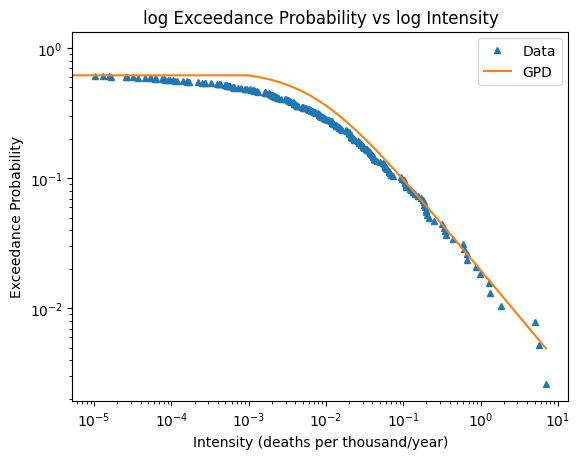

In [66]:
#draw log-log scale plot
fig, ax = plt.subplots()
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["Exceedance Probability"], '^', markersize=4)
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["GPD"]*0.62)
# cut x at 0.001
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Intensity (deaths per thousand/year)")
ax.set_ylabel("Exceedance Probability")
ax.legend(["Data", "GPD"])
ax.set_title("log Exceedance Probability vs log Intensity")
plt.show()

**Data used to fit the model is the ones > 0.001**

In [9]:
x = "Intensity (deaths per thousand/year)"
intensities = np.linspace(marani_df[x].min(), marani_df[x].max(), 1000)

In [26]:
marani_1e_3_df = marani_df[(marani_df["Intensity (deaths per thousand/year)"] > 1e-3) & (marani_df["Start Year"].between(1600, 1944))]

In [123]:
from scipy.stats import genpareto
# fit GPD with mu = 0.001
xi, mu, sigma = genpareto.fit(data = marani_1e_3_df[x],floc=0.001) # floc=0.001 is the location parameter
print(f'fitted parameters: mu={mu}, sigma={sigma}, xi={xi}') # agree with the original paper

fitted parameters: mu=0.001, sigma=0.01129066673666155, xi=1.3980986273217102


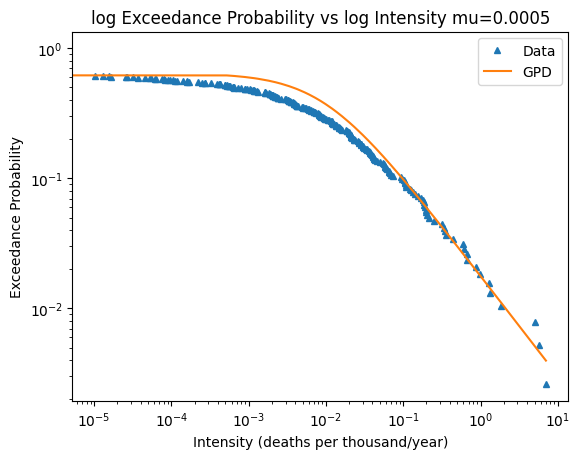

In [122]:
#draw log-log scale plot
gpd_vals = compute_gpd(x=sorted_data["Intensity (deaths per thousand/year)"], mu=mu, sigma=sigma, xi=xi)
sorted_data["GPD"] = gpd_vals
fig, ax = plt.subplots()
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["Exceedance Probability"], '^', markersize=4)
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["GPD"]*0.62)
# cut x at 0.001
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Intensity (deaths per thousand/year)")
ax.set_ylabel("Exceedance Probability")
ax.legend(["Data", "GPD"])
ax.set_title("log Exceedance Probability vs log Intensity mu=0.0005")
plt.show()

In [53]:
import numpy as np
from scipy.stats import genpareto
from scipy.optimize import minimize
import statsmodels.api as sm

# Generate some sample data from a GPD distribution
# Generate some sample data from a GPD distribution
np.random.seed(0)
data = marani_1e_3_df[x]

def neg_log_likelihood(params, data):
    scale, shape = params
    threshold = 0.001  # Fixed location parameter
    if shape == 0:
        return np.inf  # Avoid division by zero
    return -np.sum(genpareto.logpdf(data, shape, loc=threshold, scale=scale))

# Initial parameter guesses
initial_guess = (1, 0.5)

# Perform maximum likelihood estimation
result = minimize(neg_log_likelihood, initial_guess, args=(data,), method='Nelder-Mead')
scale_mle, shape_mle = result.x

# Compute Hessian matrix
def hessian(func, params, args):
    def get_gradient(func, params, args, epsilon=1e-5):
        grad = []
        for i in range(len(params)):
            params_plus = params.copy()
            params_plus[i] += epsilon
            grad.append((func(params_plus, *args) - func(params, *args)) / epsilon)
        return grad
    grad = get_gradient(func, params, args)
    hess = []
    for i in range(len(params)):
        params_plus = params.copy()
        params_plus[i] += 1e-4 * params_plus[i]
        grad_plus = get_gradient(func, params_plus, args)
        hess.append([(grad_plus[j] - grad[j]) / (1e-4 * params_plus[i]) for j in range(len(grad))])
    return np.array(hess)

hess = hessian(neg_log_likelihood, result.x, (data,))

# Compute standard errors
covariance_matrix = np.linalg.inv(hess)
scale_se, shape_se = np.sqrt(np.diagonal(covariance_matrix))

# Print MLE results and standard errors
print("Maximum Likelihood Estimation (MLE) Results:")
print("Threshold (Location) Parameter: 0.001 (fixed)")
print("Scale MLE:", scale_mle)
print("Shape MLE:", shape_mle)
print("\nStandard Errors:")
print("Scale SE:", scale_se)
print("Shape SE:", shape_se)

# Fit GPD using statsmodels
gpd_model = sm.GLM(data, sm.add_constant(np.where(data > 0.001, data - 0.001, 0)), 
                   family=sm.families.Gamma(sm.families.links.identity()))
gpd_result = gpd_model.fit()

# Print statsmodels summary
print("\nStatsmodels GLM Summary:")
print(gpd_result.summary())

Maximum Likelihood Estimation (MLE) Results:
Threshold (Location) Parameter: 0.001 (fixed)
Scale MLE: 0.011290005748011766
Shape MLE: 1.3981001450194226

Standard Errors:
Scale SE: 0.002077411213233193
Shape SE: 0.20035283862125017

Statsmodels GLM Summary:
                          Generalized Linear Model Regression Results                           
Dep. Variable:     Intensity (deaths per thousand/year)   No. Observations:                  151
Model:                                              GLM   Df Residuals:                      149
Model Family:                                     Gamma   Df Model:                            1
Link Function:                                 identity   Scale:                      2.0520e-31
Method:                                            IRLS   Log-Likelihood:                 0.0000
Date:                                  Tue, 13 Feb 2024   Deviance:                  -2.1386e-15
Time:                                          16:10:24   Pears

### Confidence Intervals
- Appendix of Marani et al.: Lines indicate the 95% confidence interval for the frequency values, computed according to **Wilson’s score** (not tried yet)
- My thought: MLE with errors, can directly calculate CI

In [104]:
# calculate the 95% confidence region for the GPD
from scipy.stats import chi2
alpha = 0.05
df = 2  # Degrees of freedom
chi2_critical = chi2.ppf(1 - alpha / 2, df)
covariance_matrix = np.linalg.inv(hess)
scale_mle, shape_mle = result.x
scale_se, shape_se = np.sqrt(np.diagonal(covariance_matrix))
scale_lower = scale_mle - np.sqrt(chi2_critical) * scale_se
scale_upper = scale_mle + np.sqrt(chi2_critical) * scale_se
shape_lower = shape_mle - np.sqrt(chi2_critical) * shape_se
shape_upper = shape_mle + np.sqrt(chi2_critical) * shape_se
print("95% Confidence Region for GPD Parameters:")
print("Scale:", (scale_lower, scale_upper))
print("Shape:", (shape_lower, shape_upper))

95% Confidence Region for GPD Parameters:
Scale: (0.005647335112994649, 0.016932676383028884)
Shape: (0.8539011573905115, 1.9422991326483336)


In [111]:
import numpy as np
from scipy.stats import multivariate_normal as mvn

dist = mvn( mean=[scale_mle,shape_se], cov=covariance_matrix )


xlim = (-0.0,0.04)
ylim = (-1,3)
  
x = np.linspace(*xlim,1000)
y = np.linspace(*ylim,1000)

X, Y = np.meshgrid(x,y)
pos = np.dstack( (X,Y) )
Z = dist.pdf(pos)

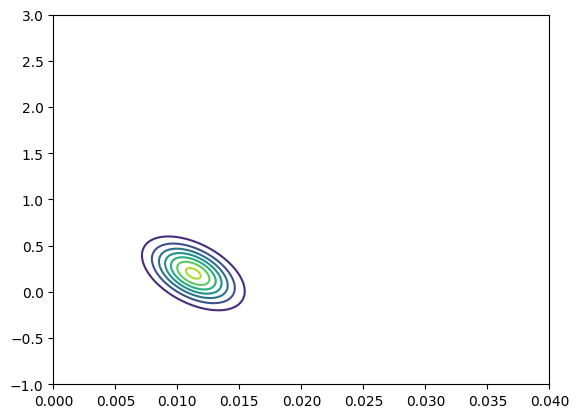

In [112]:
# contour plot
fig, ax = plt.subplots()
ax.contour(X,Y,Z)

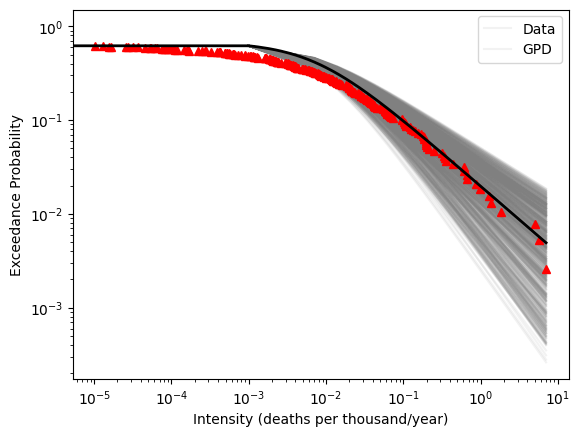

In [115]:
#draw log-log scale plot
fig, ax = plt.subplots()

# plot 95% confidence region (2D) for the fitted GPD
# parameteric sampling samples from the fitted distribution
n_samples = 1000
n_simulations = 1000
x = "Intensity (deaths per thousand/year)"
for simulation in range(n_simulations):
    # random parameters in the 95% confidence region (parobolic region)
    scale_samples = np.random.uniform(scale_lower, scale_upper)
    shape_samples = np.random.uniform(shape_lower, shape_upper)
    # discard if the cdf is less than 0.025 or greater than 0.975
    if dist.cdf([scale_samples, shape_samples]) < 0.025 or dist.cdf([scale_samples, shape_samples]) > 0.975:
        continue
    intensities = np.linspace(marani_df[x].min(), marani_df[x].max(),n_samples) 
    # setting the intensities less then 0.001 to 0.001
    intensities = np.where(intensities > 0.001, intensities, 0.001)
    gpd_vals = compute_gpd(x=intensities, mu=0.001, sigma=scale_samples, xi=shape_samples)
    ax.plot(intensities, gpd_vals * 0.62, color='gray', alpha=0.1)    

ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["Exceedance Probability"], '^', markersize=6, color='red')
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["GPD"]*0.62, color='black', linewidth=2)
ax.set_xlabel("Intensity (deaths per thousand/year)")
ax.set_ylabel("Exceedance Probability")
ax.legend(["Data", "GPD"])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

#### Chi-squared test
Note: the location parameter is chosen before maximum likelihood fit
$$
\text{degree\_of\_freedom} = \text{number\_of\_bins} - \text{number\_of\_free parameters}(2)
$$

In [128]:
# chi-squared test
import scipy.stats as stats
observed = sorted_data["Exceedance Probability"]
# expected data is concatinated from 0.62*GPD and 0.38 (for intensity < 0.001)
expected = 0.62*sorted_data["GPD"]
# we now need to bin the data
bins = np.linspace(0, 1, 21) # 20 bins
observed_counts, _ = np.histogram(observed, bins=bins)
expected_counts, _ = np.histogram(expected, bins=bins)
# perform the chi-squared test
chi2, p = stats.chisquare(observed_counts, expected_counts, ddof=20-2)
print(f'chi2={chi2}, p={p}')

chi2=inf, p=0.0


In [39]:
# Kolmogorov-Smirnov test: unbiined
ks_stat, ks_p = stats.kstest(np.log(observed), np.log(expected))
print(f"ks_stat: {ks_stat}, ks_p: {ks_p}")

ks_stat: 0.381201044386423, ks_p: 3.482947897449866e-25


Find data for vaccine multiplier
- 

## Accidental Pandemics
- Bayesian stats: impossible
- Recomputing P(release) : convert the table to csv manually? Poisson autoregressive model might suitable
(Count data + current value relates to previous values)
- p maybe too high

In [97]:
np.array([0.05,0.40])*0.00246

array([0.000123, 0.000984])

In [98]:
1/(0.000984-0.000123)

1161.4401858304298

In [101]:
num_facilities = params.Accidental.num_facilities.val
growth_rate = params.Accidental.growth_rate.val
num_years = params.Global.num_years.val

# Store the number of facilities over time
facilities_over_time = []

for year in range(num_years):
    adjusted_facilities = int(num_facilities * (1 + growth_rate) ** year)
    facilities_over_time.append(adjusted_facilities)

# Convert to a numpy array
facilities_over_time = np.array(facilities_over_time)

In [102]:
facilities_over_time

array([14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 17, 18, 18, 19, 19, 20, 20,
       21, 21, 22, 22, 23, 24, 24, 25, 25, 26, 27, 27, 28, 29, 30, 30, 31,
       32, 33, 34, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48,
       49, 50, 51, 53, 54, 55, 57, 58, 60, 61, 63, 64, 66, 67, 69, 71, 73,
       75, 76, 78, 80, 82, 84, 87, 89])

- Deliberate 1 is actually down, so maybe try to push to your depo?
- just over-write!
- equipment to make virus = for vaccines
- 